In [1]:
import torch
from ddpm import model
import matplotlib.pyplot as plt

from ddpm.utils.loading import generate_model_and_task_from_args_path_multiepoch

device = 'cuda'

In [2]:
def replace_nullspace_activity_partway_through_generation(diffusion_model, network_input, post_prep_state, replacement_activity, replacement_t_idx):
    """
    replacement_activity can be rich in the behaviour space too - nullspace activity will be extracted here!
    """
    assert isinstance(diffusion_model, model.PreparatoryLinearSubspaceTeacherForcedDDPMReverseProcess)

    network_input_mult = 1.0 if diffusion_model.network_input_during_diffusion else 0.0

    midway_samples_dict = super(type(diffusion_model), diffusion_model).generate_samples(
        network_input = network_input * network_input_mult,
        samples_shape = None,
        base_samples = post_prep_state,
        noise_scaler = 1.0,
        kwargs_for_residual_model = {},
        start_t_idx = 1,
        end_t_idx = replacement_t_idx
    )

    if replacement_activity is not None:
        assert post_prep_state.shape == replacement_activity.shape
        replacement_activity_nullspace = replacement_activity @ diffusion_model.behaviour_nullspace_accessor
    else:
        replacement_activity_nullspace = midway_samples_dict['end_state'].flip(0)    

    midway_state = midway_samples_dict['end_state']
    midway_state = midway_state - (midway_state @ diffusion_model.behaviour_nullspace_accessor)
    midway_state = midway_state + replacement_activity_nullspace

    end_samples_dict = super(type(diffusion_model), diffusion_model).generate_samples(
        network_input = network_input * network_input_mult,
        samples_shape = None,
        base_samples = midway_state,
        noise_scaler = 1.0,
        kwargs_for_residual_model = {},
        start_t_idx = replacement_t_idx + 1,
        end_t_idx = None
    )

    return midway_samples_dict, end_samples_dict

### Network trained without stimulus does!

In [19]:
run_name = 'run_e2_probe_cued_factorised_palimpsest_rnn_baseline_long_diff_and_del_0'
# run_name = 'run_e3_probe_cued_factorised_palimpsest_no_swap_long_diff_and_del_0'
# run_name = 'run_e5_probe_cued_factorised_palimpsest_cyclical_swap_0'
# run_name = 'run_e4_probe_cued_factorised_palimpsest_flat_swap_0'

device = 'cuda'
_, task, ddpm_model, _ = generate_model_and_task_from_args_path_multiepoch(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/ddpm_conjuctions_investigation_20250317/{run_name}/args.yaml', device)
ddpm_model.load_state_dict(torch.load(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/ddpm_conjuctions_investigation_20250317/{run_name}/state.mdl'))

/tmp/ipykernel_3857007/3167363024.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ddpm_model.load_state_dict(torch.load(f'/homes/pr450/repos/research_projects/sampling_d

<All keys matched successfully>

Text(0.5, 1.0, '')

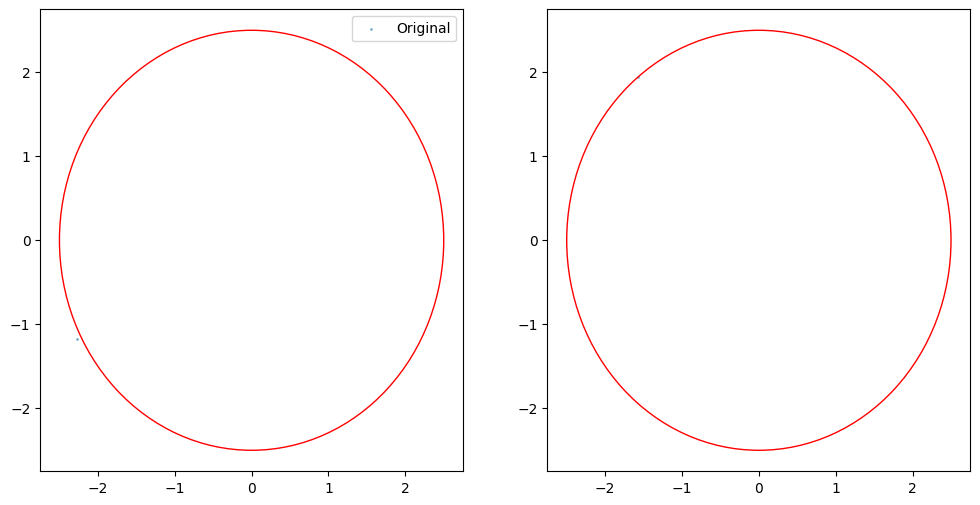

In [20]:
batch_size = 512
num_samples = 1

trial_information = task.generate_trial_information(batch_size=batch_size, num_samples=num_samples)

with torch.no_grad():
    novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
        # prep_network_inputs=[
        #     pni[[0]] for pni in trial_information.prep_network_inputs
        # ],
        # diffusion_network_inputs=[
        #     dni[[0]] for dni in trial_information.diffusion_network_inputs
        # ],
        prep_network_inputs = trial_information.prep_network_inputs,
        diffusion_network_inputs = trial_information.diffusion_network_inputs,
        prep_epoch_durations=trial_information.prep_epoch_durations,
        diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
        samples_shape=[batch_size, num_samples],
        noise_scaler=1.0,
    )

fig,axes = plt.subplots(1, 2, figsize = (12, 6))
for i in range(2):
    # task.task_variable_gen.display_task_variables(trial_information.task_variable_information, axes[i])
    task.sample_gen.display_samples(novel_samples_dict['samples'][[i]], axes[i], label = 'Original')

axes[0].legend()

axes[0].set_title('')
axes[1].set_title('')

In [21]:
from purias_utils.error_modelling_torus.non_parametric_error_model.setup_utils import setup_model_whole

emission_type = 'von_mises'
kernel_type = 'weiland'
trainable_kernel_delta = False
normalisation_inner = 'exp'
inducing_point_variational_parameterisation_type = 'gaussian'
init_min_seps = False
all_set_sizes = [2]
R_per_dim = 12
fix_inducing_point_locations = False
fix_non_swap = True
include_pi_1_tilde = False
include_pi_u_tilde = True
monte_carlo_gp_samples = 1024
remove_uniform = False
resume_path = None
shared_emission_distribution = False
shared_swap_function = False
swap_type = 'cue_dim_only'
symmetricality_constraint = True

min_sep = torch.pi / 7.1

num_models = 1


swap_model, D, delta_dimensions = setup_model_whole(
    num_models = num_models,
    swap_type = swap_type,
    kernel_type = kernel_type,
    emission_type = emission_type,
    all_set_sizes = all_set_sizes,
    remove_uniform = remove_uniform,
    include_pi_u_tilde = include_pi_u_tilde,
    trainable_kernel_delta = trainable_kernel_delta,
    R_per_dim = R_per_dim,
    fix_non_swap = fix_non_swap,
    include_pi_1_tilde = include_pi_1_tilde,
    fix_inducing_point_locations = fix_inducing_point_locations,
    symmetricality_constraint = symmetricality_constraint,
    shared_swap_function = shared_swap_function,
    shared_emission_distribution = shared_emission_distribution,
    all_min_seps = torch.tensor([[min_sep, min_sep]]),
    inducing_point_variational_parameterisation_type=inducing_point_variational_parameterisation_type,
    normalisation_inner= normalisation_inner,
    num_variational_samples = monte_carlo_gp_samples,
    num_importance_sampling_samples = monte_carlo_gp_samples,
    device=device,
    resume_path = None,
)

Initialising generative_model after 0 failed attempts at stability...


(array([ 2.,  1.,  4.,  5., 11., 16., 37., 45., 65., 51., 53., 67., 45.,
        39., 28., 14., 11.,  9.,  4.,  3.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.39583239, -0.35719363, -0.31855488, -0.27991613, -0.24127737,
        -0.20263862, -0.16399987, -0.12536111, -0.08672236, -0.04808361,
        -0.00944485,  0.0291939 ,  0.06783265,  0.10647141,  0.14511016,
         0.18374891,  0.22238767,  0.26102642,  0.29966517,  0.33830392,
         0.37694268,  0.41558143,  0.45422018,  0.49285894,  0.53149769,
         0.57013644,  0.6087752 ,  0.64741395,  0.6860527 ,  0.72469146,
         0.76333021,  0.80196896,  0.84060772,  0.87924647,  0.91788522,
         0.95652398,  0.99516273,  1.03380148,  1.07244024,  1.11107899,
         1.14971774,  1.1883565 ,  1.22699525,  1.265634  ,  1.30427276,
         1.34291151,  1.38155026,  1.42018902,  1.45882777,

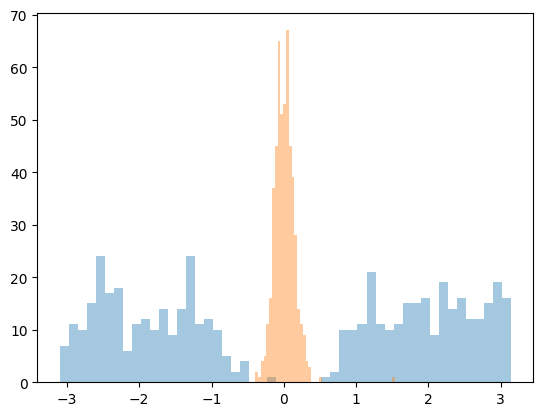

In [22]:
from purias_utils.multiitem_working_memory.util.circle_utils import rectify_angles

cued_idx = trial_information.task_variable_information['cued_item_idx']

all_probe_values = rectify_angles(trial_information.task_variable_information['probe_features'])
probe_values = torch.zeros_like(all_probe_values)
probe_values[torch.arange(batch_size),0] = all_probe_values[torch.arange(batch_size),cued_idx]
probe_values[torch.arange(batch_size),1] = all_probe_values[torch.arange(batch_size),1-cued_idx]
probe_deltas = rectify_angles(probe_values - probe_values[:,[0]])
deltas_batch = probe_deltas.unsqueeze(-1).unsqueeze(0).repeat_interleave(num_models, 0)


all_report_values = rectify_angles(trial_information.task_variable_information['report_features'])
report_values = torch.zeros_like(all_report_values)
report_values[torch.arange(batch_size),0] = all_report_values[torch.arange(batch_size),cued_idx]
report_values[torch.arange(batch_size),1] = all_report_values[torch.arange(batch_size),1-cued_idx]

responses_cart = novel_samples_dict['samples'].squeeze(1)
responses = torch.arctan2(responses_cart[:,1], responses_cart[:,0]).unsqueeze(-1)


errors = rectify_angles(responses - report_values)
errors_batch = errors.unsqueeze(0).repeat_interleave(num_models, 0)

plt.hist(errors[:,1], 50, alpha = 0.4)
plt.hist(errors[:,0], 50, alpha = 0.4)

  0%|          | 0/6000 [00:00<?, ?it/s]

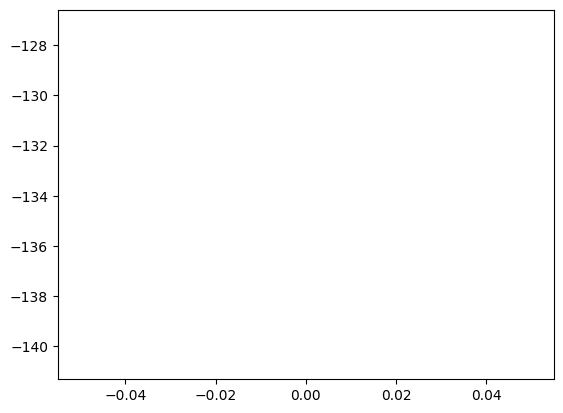

  1%|          | 50/6000 [00:08<15:25,  6.43it/s]

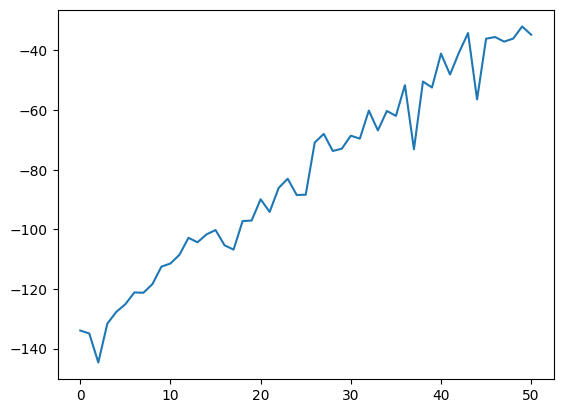

  2%|▏         | 100/6000 [00:16<14:56,  6.58it/s]

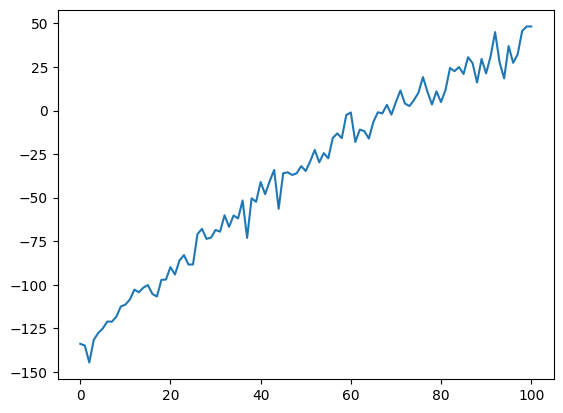

  2%|▎         | 150/6000 [00:23<10:59,  8.87it/s]

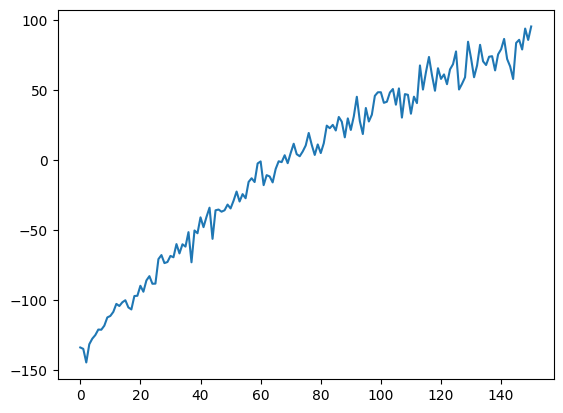

  3%|▎         | 200/6000 [00:30<15:14,  6.34it/s]

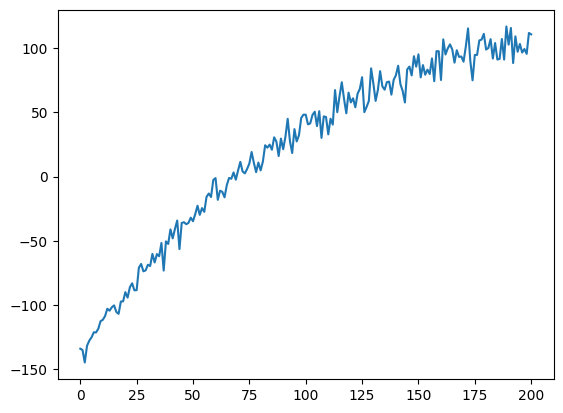

  4%|▍         | 250/6000 [00:38<13:19,  7.19it/s]

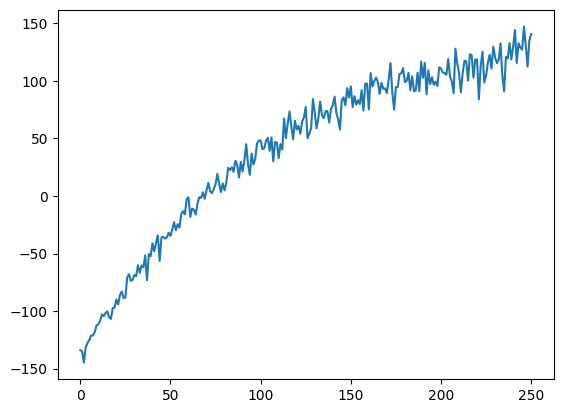

  5%|▌         | 300/6000 [00:47<15:00,  6.33it/s]

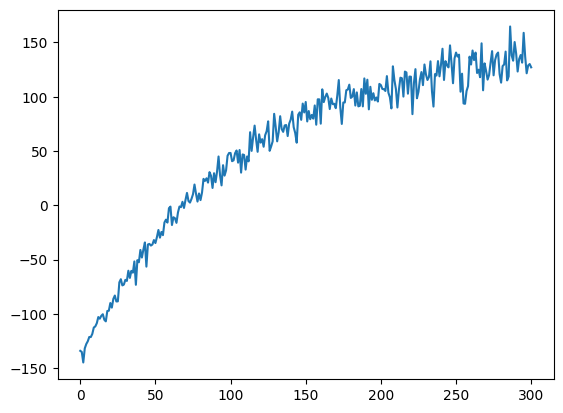

  6%|▌         | 350/6000 [00:55<15:21,  6.13it/s]

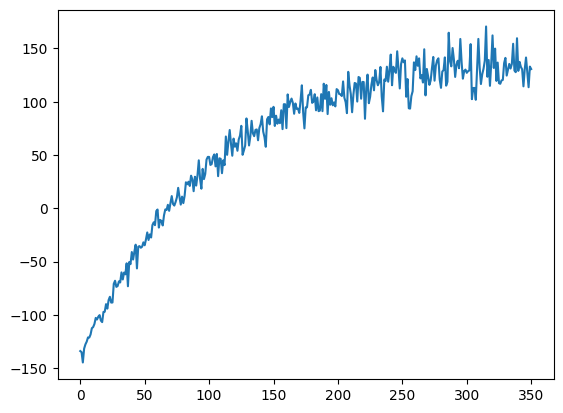

  7%|▋         | 400/6000 [01:04<17:13,  5.42it/s]

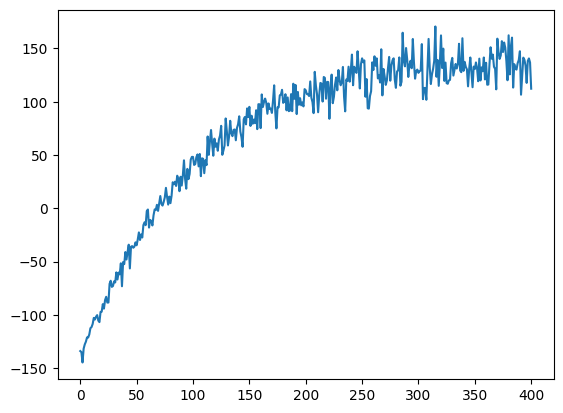

  8%|▊         | 450/6000 [01:12<15:03,  6.14it/s]

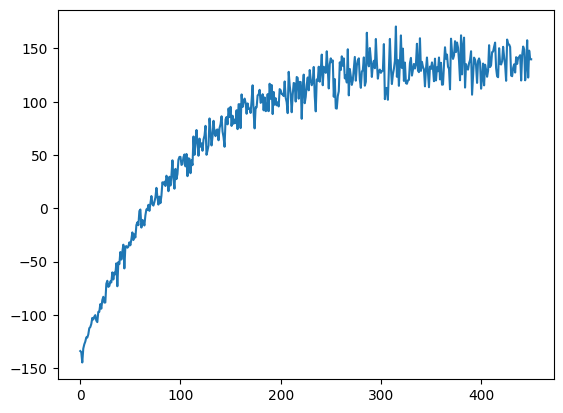

  8%|▊         | 500/6000 [01:21<14:19,  6.40it/s]

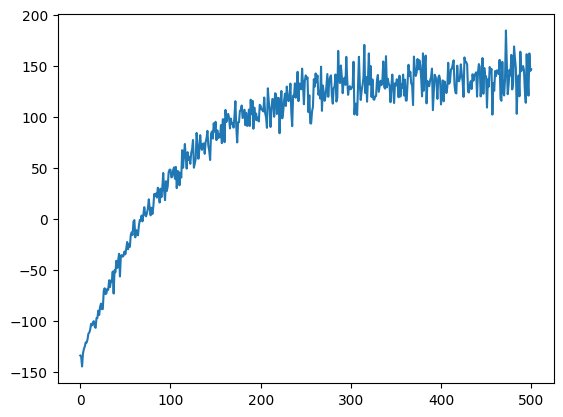

  9%|▉         | 550/6000 [01:29<17:43,  5.13it/s]

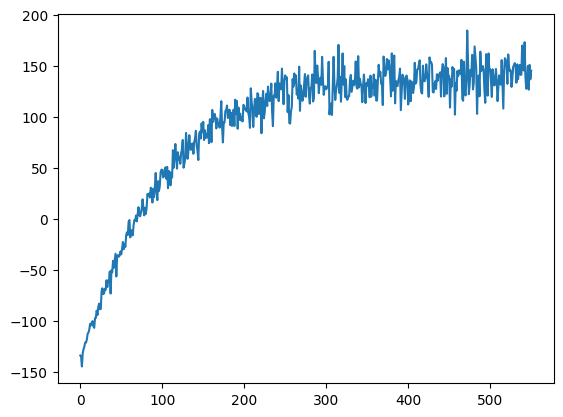

 10%|█         | 600/6000 [01:38<14:32,  6.19it/s]

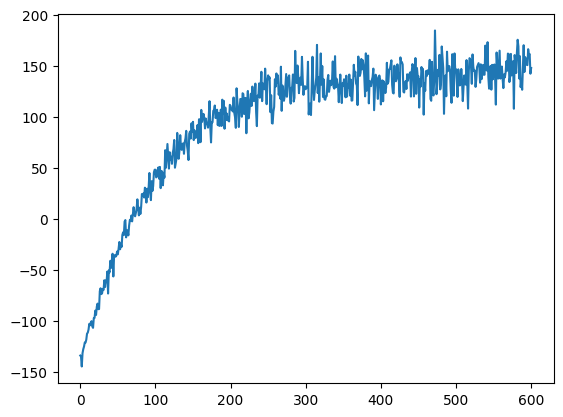

 11%|█         | 650/6000 [01:47<16:39,  5.35it/s]

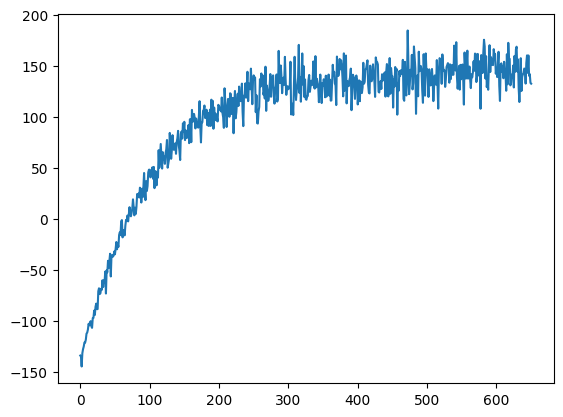

 11%|█▏        | 682/6000 [01:52<14:39,  6.05it/s]


KeyboardInterrupt: 

In [23]:
from tqdm import tqdm
import numpy as np

batch_size = 256
num_samples = 1
flip_augmentation = True

opt = torch.optim.Adam(swap_model.parameters(), lr = 0.01)

swap_model.cuda()

all_llh = []


infinite_data_mode = True


for i in tqdm(range(6000)):

    if infinite_data_mode or i == 0:

        trial_information = task.generate_trial_information(batch_size=batch_size, num_samples=num_samples)

        with torch.no_grad():
            novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
                # prep_network_inputs=[
                #     pni[[0]] for pni in trial_information.prep_network_inputs
                # ],
                # diffusion_network_inputs=[
                #     dni[[0]] for dni in trial_information.diffusion_network_inputs
                # ],
                prep_network_inputs = trial_information.prep_network_inputs,
                diffusion_network_inputs = trial_information.diffusion_network_inputs,
                prep_epoch_durations=trial_information.prep_epoch_durations,
                diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
                samples_shape=[batch_size, num_samples],
                noise_scaler=1.0,
            )


        cued_idx = trial_information.task_variable_information['cued_item_idx']

        all_probe_values = rectify_angles(trial_information.task_variable_information['probe_features'])
        probe_values = torch.zeros_like(all_probe_values)
        probe_values[torch.arange(batch_size),0] = all_probe_values[torch.arange(batch_size),cued_idx]
        probe_values[torch.arange(batch_size),1] = all_probe_values[torch.arange(batch_size),1-cued_idx]
        probe_deltas = rectify_angles(probe_values - probe_values[:,[0]])
        deltas_batch = probe_deltas.unsqueeze(-1).unsqueeze(0).repeat_interleave(num_models, 0)

        all_report_values = rectify_angles(trial_information.task_variable_information['report_features'])
        report_values = torch.zeros_like(all_report_values)
        report_values[torch.arange(batch_size),0] = all_report_values[torch.arange(batch_size),cued_idx]
        report_values[torch.arange(batch_size),1] = all_report_values[torch.arange(batch_size),1-cued_idx]

        responses_cart = novel_samples_dict['samples'].squeeze(1)
        responses = torch.arctan2(responses_cart[:,1], responses_cart[:,0]).unsqueeze(-1)

        errors = rectify_angles(responses - report_values)
        errors_batch = errors.unsqueeze(0).repeat_interleave(num_models, 0)


    if flip_augmentation:
        augmentation_map_deltas = (2 * (torch.rand_like(deltas_batch) < 0.5).int()) - 1
        deltas_batch = deltas_batch * augmentation_map_deltas.to(dtype = deltas_batch.dtype, device = deltas_batch.device)

        augmentation_map_errors = (2 * (torch.rand_like(errors_batch) < 0.5).int()) - 1
        errors_batch = errors_batch * augmentation_map_errors.to(dtype = errors_batch.dtype, device = deltas_batch.device)

    training_info = swap_model.get_elbo_terms(deltas = deltas_batch.cuda(), data = errors_batch.cuda(), max_variational_batch_size = 64)

    opt.zero_grad()

    selected_beta = 1.0
    total_elbo = (training_info['total_log_likelihood'] - selected_beta * training_info['kl_term'])
    total_loss = - total_elbo

    total_loss.sum().backward()
    opt.step()

    all_llh.append(training_info['total_log_likelihood'].item())

    torch.cuda.empty_cache()

    if i % 50 == 0:
        plt.close('all')
        plt.plot(all_llh)
        plt.show()


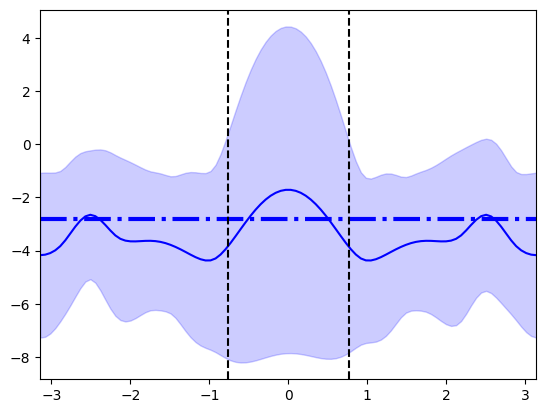

In [24]:
inference_info = swap_model.inference_on_grid(set_size=2, grid_count=100)
one_dimensional_grid = inference_info['one_dimensional_grid']
all_grid_points = inference_info['all_grid_points']
mean_surface = inference_info['mean_surface']
std_surface = inference_info['std_surface']
function_samples_on_grid = inference_info['function_samples_on_grid']

q = 0
qth_mean_surface = mean_surface[q]
qth_lower_surface, qth_upper_surface = qth_mean_surface - 2 * std_surface[q], qth_mean_surface + 2 * std_surface[q]

display_pi_u_tilde = swap_model.generative_model.swap_function.pi_u_tilde_holder['2'].pi_tilde.detach().cpu()

surface_color = 'blue'

fig, axes = plt.subplots(1)

axes.plot(one_dimensional_grid, qth_mean_surface, color = 'blue')[0].get_color()
axes.fill_between(one_dimensional_grid, qth_lower_surface, qth_upper_surface, color = surface_color, alpha = 0.2)
axes.plot([-torch.pi, torch.pi], [display_pi_u_tilde[q].item(), display_pi_u_tilde[q].item()], surface_color, linestyle= '-.', linewidth = 3)

y_bot, y_top = axes.get_ylim()
sep = torch.pi/4.1
axes.plot([sep, sep], [y_bot, y_top], color = 'black', linestyle = '--')
axes.plot([-sep, -sep], [y_bot, y_top], color = 'black', linestyle = '--')
axes.set_ylim(y_bot, y_top)
axes.set_xlim(-torch.pi, torch.pi)

if 'cyclical' in run_name:
    cued_probe_sq_distance = rectify_angles(deltas_batch).square()

    true_swap_func = -0.5 * (deltas_batch.square() / (2.0 + 2e-5))
    axes.scatter(deltas_batch[0].flatten(), true_swap_func.flatten(), color = 'red', alpha = 0.4, s = 5)

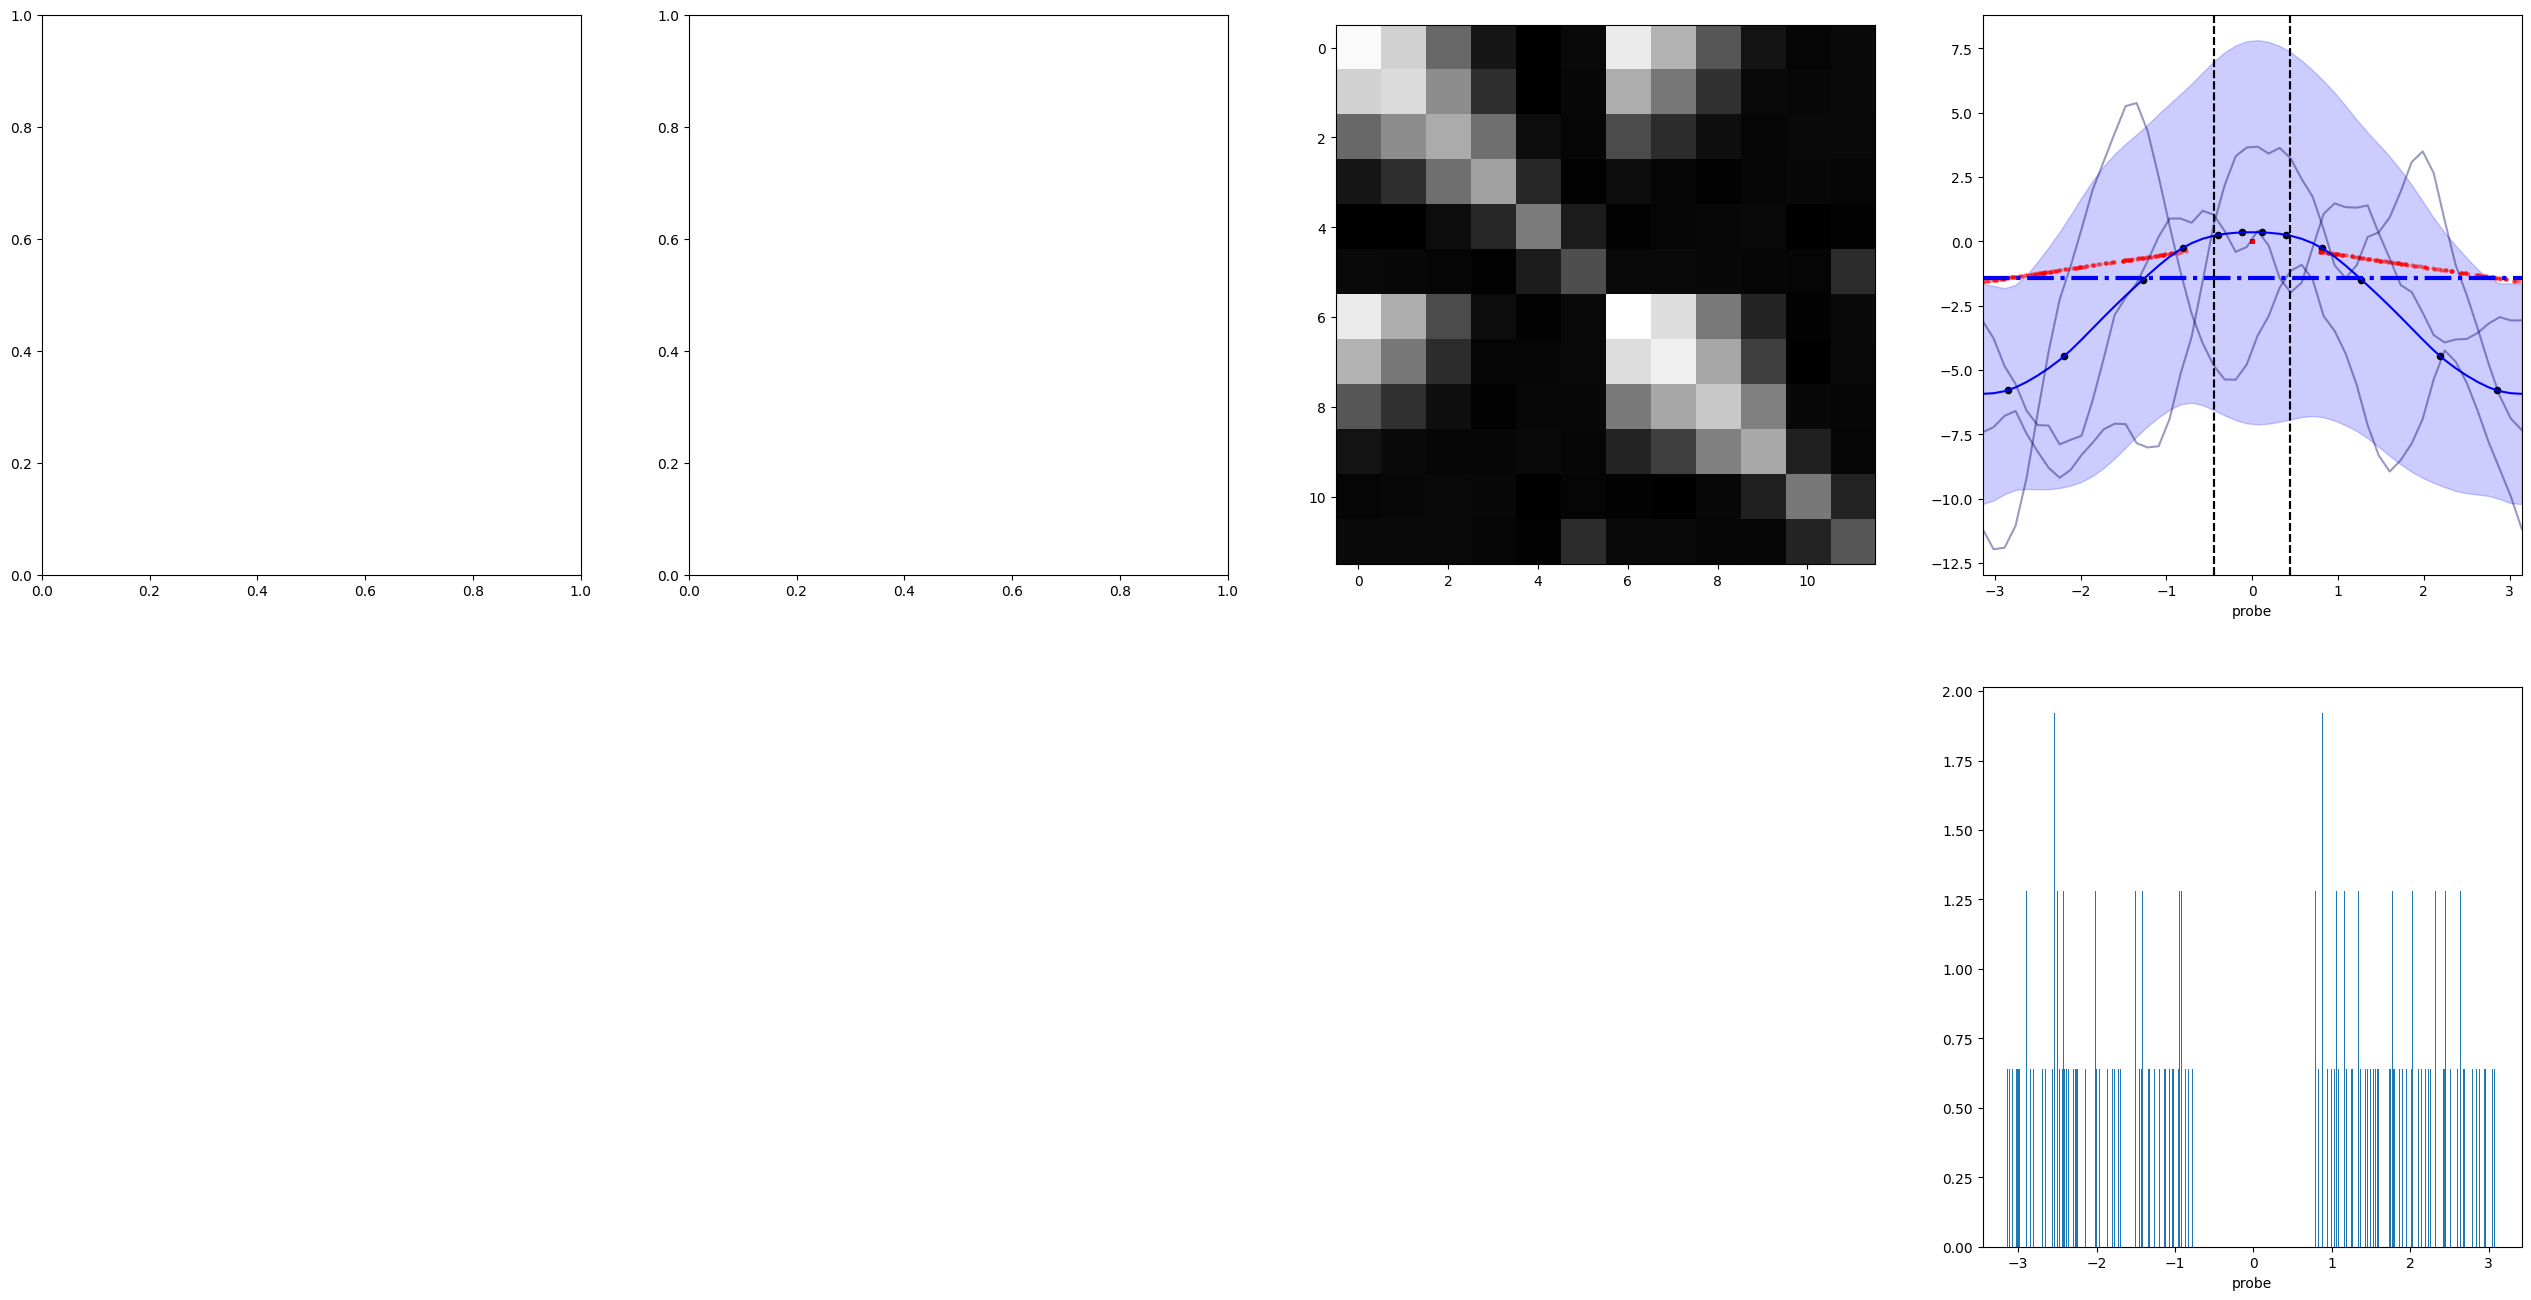

In [17]:
display_pi_u_tilde = swap_model.generative_model.swap_function.pi_u_tilde_holder['2'].pi_tilde.detach().cpu()
display_pi_1_tilde = display_pi_u_tilde * np.nan



fig_surfaces, fig_surfaces_num_rows, fig_surfaces_num_cols = swap_model.visualise_variational_approximation(
    set_size = 2, grid_count = 50,
    pi_u_tildes = display_pi_u_tilde.detach().cpu(),
    pi_1_tildes = display_pi_1_tilde.detach().cpu(), 
    all_deltas = deltas_batch[0],
    recent_component_priors = None,# training_info['priors'].detach().cpu(),
    true_mean_surface = -0.5 * (deltas_batch.abs() / (1.0 + 2e-5)),
    true_std_surface = None,
    min_separation= [min_sep],
    max_separation= [min_sep],
    deltas_label = ['probe']
)

Representational siimarlity analysis

In [6]:
fixed_delay_duration = 30
ctd_batch_size = 1024
num_rsa_samples = 512


trial_information = task.generate_trial_information(batch_size=ctd_batch_size, num_samples=num_rsa_samples)

trial_information.task_variable_information['prep_epoch_durations'][1] = fixed_delay_duration

with torch.no_grad():
    novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
        # prep_network_inputs=[
        #     pni[[0]] for pni in trial_information.prep_network_inputs
        # ],
        # diffusion_network_inputs=[
        #     dni[[0]] for dni in trial_information.diffusion_network_inputs
        # ],
        prep_network_inputs = trial_information.prep_network_inputs,
        diffusion_network_inputs = trial_information.diffusion_network_inputs,
        prep_epoch_durations=trial_information.prep_epoch_durations,
        diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
        samples_shape=[ctd_batch_size, num_rsa_samples],
        noise_scaler=1.0,
    )

In [7]:
#stimulus_exposure
#pre_index_delay
#index
#post_index_delay

for nspd in novel_samples_prep_dicts:
    print(nspd.keys(), nspd['preparatory_trajectory'].shape)
print(novel_samples_dict.keys(), novel_samples_dict['embedded_sample_trajectory'].shape)

dict_keys(['preparatory_trajectory', 'postprep_state', 'postprep_base_samples']) torch.Size([1024, 1, 10, 128])
dict_keys(['preparatory_trajectory', 'postprep_state', 'postprep_base_samples']) torch.Size([1024, 1, 30, 128])
dict_keys(['preparatory_trajectory', 'postprep_state', 'postprep_base_samples']) torch.Size([1024, 1, 5, 128])
dict_keys(['preparatory_trajectory', 'postprep_state', 'postprep_base_samples']) torch.Size([1024, 1, 1, 128])
dict_keys(['end_state', 'sample_trajectory', 'embedded_sample_trajectory', 'samples', 'early_x0_preds', 'epsilon_hat']) torch.Size([1024, 1, 40, 128])


First, we just try a linear decoder, to see items are stored in order of stimulus (which would be unfortunate)